# DL model to forecast store sales data in Ecuador

This is my 6-week school homework for "intro to deep learning" class by CU Boulder on Coursera. We assume this notebook will run on GPU.

## Abstraction

The notebook goal is to forecast store sales on time-series data, from Ecuadorian-based grocery store. The sales target is continuous value so it is regression task. The prediction will be made on the unit sales for thousands of items sold at different stores in Ecuador.

We make deep learning model, using entity embedding to categorical data. The data is formated in tabular, like excel so we need some way to change categorical features into some numeric value for training the model. Entity embedding will work for such a feature engineering to categorical data. The technique works to map the high cardinality categorical variable to a low-dimensional vector space, where each category is represented as a vector of fixed dimensionality. We will discuss more detail in model building section. The evaluation metric for this competition is Root Mean Squared Logarithmic Error as is used on the original competition's.

The notebook's workflow are:

1. Load libraries
2. Get the dataset
3. EDA
4. Feature engineering
5. Build and evaluate model
6. Interprete model with empty embedding
7. Discussion/conclusion

The original competition is hosted in [kaggle competition page](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview). You can install the same dataset as we use in this notebook at the competition page. The original paper for entity embedding is [here](https://arxiv.org/abs/1604.06737).

**keywords**: GPU, Keras, Regression Task, RMSLE, Entity Embedding

## Load libraries

In [64]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.core.display import Image, display
import matplotlib.pyplot as plt
from sklearn import manifold

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, GRU, Reshape, BatchNormalization, LeakyReLU, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, LSTM, Attention, GlobalMaxPool1D, CategoryEncoding
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.schedules import CosineDecay

path = Path("/kaggle/input/store-sales-time-series-forecasting")
!ls {path}

holidays_events.csv  sample_submission.csv  test.csv   transactions.csv
oil.csv		     stores.csv		    train.csv


## Get the training dataset

We load train dataset with some metadata. We will see each data more later. The training contains `3000888 ` entries, while date and other columns relationship are one to many. We need to convert our dataframe so that each rows contains one day data with all kind family and store.

In [65]:
df_train = pd.read_csv(path/"train.csv")
# df_test = pd.read_csv(path/"test.csv")
df_oil = pd.read_csv(path/"oil.csv")
df_holiday = pd.read_csv(path/"holidays_events.csv")

print("train data shape: ", df_train.shape)
# print("test data shape: ", df_test.shape)
print("oil data shape: ", df_oil.shape)
print("holiday data shape: ", df_holiday.shape)

train data shape:  (3000888, 6)
oil data shape:  (1218, 2)
holiday data shape:  (350, 6)


In [66]:
print("train set")
df_train.head(3)

train set


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0


We transform our training set. That way each row contains just one day's sales to each store's each item. For instance, first row's second columns holds `store number 1's` `automotive` sales in `2013-01-01`.


In [67]:
df_train = pd.pivot_table(df_train, index='date', columns=['store_nbr', 'family'], values='sales')
df_train = df_train.reset_index()

df_train.columns = ['_'.join(map(str, col)).strip() for col in df_train.columns.values]

df_train = df_train.rename(columns={'date_': 'date'})
df_train.describe()

,1_AUTOMOTIVE,1_BABY CARE,1_BEAUTY,1_BEVERAGES,1_BOOKS,1_BREAD/BAKERY,1_CELEBRATION,1_CLEANING,1_DAIRY,1_DELI,...,54_MAGAZINES,54_MEATS,54_PERSONAL CARE,54_PET SUPPLIES,54_PLAYERS AND ELECTRONICS,54_POULTRY,54_PREPARED FOODS,54_PRODUCE,54_SCHOOL AND OFFICE SUPPLIES,54_SEAFOOD
count,1684.000000,1684.0,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,...,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000,1684.000000
mean,3.251188,0.0,2.408551,1587.748812,0.125297,338.475183,9.967933,640.454276,626.100950,122.943633,...,0.453088,52.085961,182.085511,0.102138,1.969121,52.784924,61.217340,354.026315,0.607482,1.744656
std,2.759605,0.0,1.898950,726.870056,0.536578,111.286290,33.235438,218.090718,211.156683,41.169440,...,0.897376,16.559475,77.176256,0.384204,2.661804,26.526857,28.508794,318.035699,2.966594,2.260277
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.0,1.000000,970.750000,0.000000,281.385000,0.000000,569.750000,445.500000,100.753250,...,0.000000,40.892499,125.000000,0.000000,0.000000,35.977250,41.000000,0.000000,0.000000,0.000000
50%,3.000000,0.0,2.000000,1674.000000,0.000000,357.842500,6.000000,677.000000,671.000000,127.421000,...,0.000000,51.264500,168.000000,0.000000,1.000000,49.175500,60.000000,426.005000,0.000000,1.000000
75%,5.000000,0.0,3.000000,2206.000000,0.000000,420.845000,16.000000,774.000000,786.250000,150.448500,...,1.000000,62.059749,223.000000,0.000000,3.000000,64.776500,80.000000,596.338025,0.000000,3.000000
max,19.000000,0.0,12.000000,5051.000000,8.000000,745.513000,1306.000000,1659.000000,1225.000000,269.448000,...,8.000000,126.090000,681.000000,3.000000,25.000000,353.715000,179.000000,1693.626000,51.000000,24.000000


In [68]:
df_train.head(3)

,date,1_AUTOMOTIVE,1_BABY CARE,1_BEAUTY,1_BEVERAGES,1_BOOKS,1_BREAD/BAKERY,1_CELEBRATION,1_CLEANING,1_DAIRY,...,54_MAGAZINES,54_MEATS,54_PERSONAL CARE,54_PET SUPPLIES,54_PLAYERS AND ELECTRONICS,54_POULTRY,54_PREPARED FOODS,54_PRODUCE,54_SCHOOL AND OFFICE SUPPLIES,54_SEAFOOD
0,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
1,2013-01-02,2.0,0.0,2.0,1091.0,0.0,470.652,0.0,1060.0,579.0,...,0.0,73.771,228.0,0.0,0.0,15.514,61.0,0.0,0.0,3.0
2,2013-01-03,3.0,0.0,0.0,919.0,0.0,310.655,0.0,836.0,453.0,...,0.0,50.257,156.0,0.0,0.0,4.313,1.0,0.0,0.0,2.0


After transformation, we get many column's dataset. 
Important factors of our dataset are:

* Target value are many, like `1782` number's sales value. Our model will tackle on those multiple regression task to predict `1782` item's sales per day.
* The time range are between `2013-3-1` to `2017-8-15`, total entries are `1684`
* All target contains some value, so there's no null values

In [69]:
target_cols = df_train.columns[1:]
target_cols

Index(['1_AUTOMOTIVE', '1_BABY CARE', '1_BEAUTY', '1_BEVERAGES', '1_BOOKS',
       '1_BREAD/BAKERY', '1_CELEBRATION', '1_CLEANING', '1_DAIRY', '1_DELI',
       ...
       '54_MAGAZINES', '54_MEATS', '54_PERSONAL CARE', '54_PET SUPPLIES',
       '54_PLAYERS AND ELECTRONICS', '54_POULTRY', '54_PREPARED FOODS',
       '54_PRODUCE', '54_SCHOOL AND OFFICE SUPPLIES', '54_SEAFOOD'],
      dtype='object', length=1782)

## EDA

Let's first see each targets plot. How diviate are those during the dataset's timespan?

What we found:
* Most of the day' sales are under 10000, but few items are more than 100000. That diviation would make it diffucult for model to fit this data.We might need to convert them, like log or log1p.

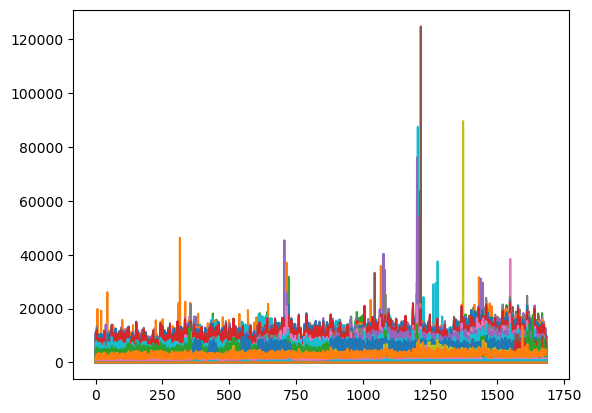

In [70]:
plt.plot(df_train[target_cols])
plt.show()

Ok, we saw target's plot. What about each target's type. Are there any missing value?

The thinng we found:
* There's no missing value
* All target's are numeric, so no need to convert

In [71]:
print(df_train.info())
print(df_train.isnull().sum(axis=0))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Columns: 1783 entries, date to 54_SEAFOOD
dtypes: float64(1782), object(1)
memory usage: 22.9+ MB
None
date                             0
1_AUTOMOTIVE                     0
1_BABY CARE                      0
1_BEAUTY                         0
1_BEVERAGES                      0
                                ..
54_POULTRY                       0
54_PREPARED FOODS                0
54_PRODUCE                       0
54_SCHOOL AND OFFICE SUPPLIES    0
54_SEAFOOD                       0
Length: 1783, dtype: int64


Next, we will see the oil price data. Equador are huge impacted by oil's price in their business. We found it is reasonable to include each day's oil price to predict store's item's sales in that context.

What we found:
* Some null value exits
* Not all data exits in the time span of training/test sets.
* Oil data are fluctuated, range from 26 to 110.

In [72]:
print(df_oil.info())
print(df_oil.isnull().sum(axis=0))
df_oil.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None
date           0
dcoilwtico    43
dtype: int64


,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


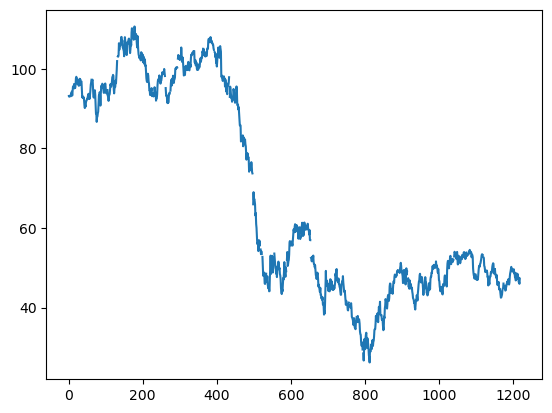

In [73]:
plt.plot(df_oil.dcoilwtico)

We fill na with next day's oil value.

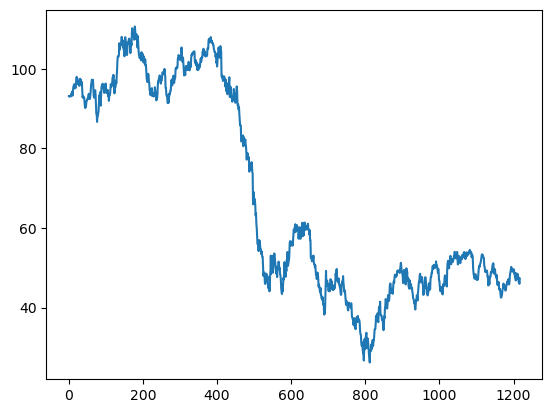

In [74]:
df_oil.dcoilwtico = df_oil.dcoilwtico.fillna(method='bfill')
plt.plot(df_oil.dcoilwtico.fillna(method='bfill'))

We next see holidays metadata.

What we found are:
* Some holiday are transfered to other days. Thus, transfered day are just normal working day.
* No null value
* Most frequent holidat are national one, locale and regional are following.

In [75]:
# df_holiday = df_holiday[df_holiday.transferred == False]
print(df_holiday.info())
print(df_holiday.isnull().sum(axis=0))
df_holiday.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338


In [76]:
print(df_holiday.type.value_counts())
print(df_holiday.locale.value_counts())

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64
National    174
Local       152
Regional     24
Name: locale, dtype: int64


## Feature engineering

Based on EDA result, we assume that target diviation would make it difficulut for model to learn. Thus, we convert sales to log. We use `tf.math.log1p`. One thing to note is we need to invert this log sales value to the original when we evaluate the model's performance.

In [77]:
log_sales = tf.math.log1p(df_train[target_cols])
for i, target in enumerate(target_cols):
    df_train[target] = log_sales[:, i]

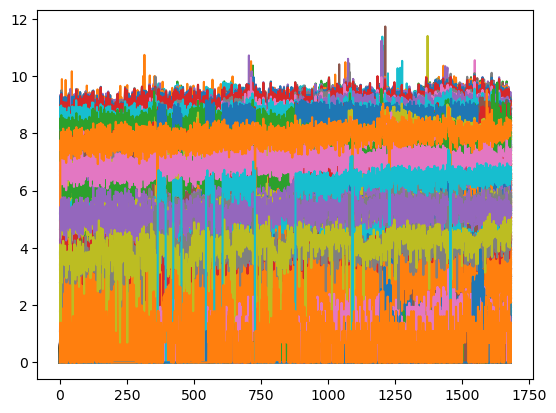

In [78]:
plt.plot(df_train[target_cols])
plt.show()

After changing target's scale, we merge oil price and holiday metadata to our training set.

In [79]:
# Merge oil data
df_train = df_train.merge(df_oil, how="left", on="date")
df_train["dcoilwtico"] = df_train["dcoilwtico"].fillna(method='bfill')

# Merge holiday data
df_holiday = df_holiday[df_holiday.transferred == False][["date", "type", "locale_name"]]
df_train = df_train.merge(df_holiday, how="left", on="date")
df_train["type"] = df_train["type"].fillna("")
df_train["locale_name"] = df_train["locale_name"].fillna("")

df_train.head(2)

,date,1_AUTOMOTIVE,1_BABY CARE,1_BEAUTY,1_BEVERAGES,1_BOOKS,1_BREAD/BAKERY,1_CELEBRATION,1_CLEANING,1_DAIRY,...,54_PET SUPPLIES,54_PLAYERS AND ELECTRONICS,54_POULTRY,54_PREPARED FOODS,54_PRODUCE,54_SCHOOL AND OFFICE SUPPLIES,54_SEAFOOD,dcoilwtico,type,locale_name
0,2013-01-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,93.14,Holiday,Ecuador
1,2013-01-02,1.098612,0.0,1.098612,6.995766,0.0,6.156241,0.0,6.966967,6.363028,...,0.0,0.0,2.804209,4.127134,0.0,0.0,1.386294,93.14,,


Lastly, we split date into 3 part, `year`, `month`, and `day`.

In [80]:
df_train["date"] = pd.to_datetime(df_train["date"], infer_datetime_format=True)
df_train["day"] = df_train["date"].dt.day
df_train["month"] = df_train["date"].dt.month
df_train["year"] = df_train["date"].dt.year

Let's see each feature in the below map

In [81]:
df_train.agg(["min", "max", "nunique"]).T

,min,max,nunique
date,2013-01-01 00:00:00,2017-08-15 00:00:00,1684
1_AUTOMOTIVE,0.0,2.995732,20.0
1_BABY CARE,0.0,0.0,1.0
1_BEAUTY,0.0,2.564949,13.0
1_BEVERAGES,0.0,8.527539,1107.0
...,...,...,...
type,,Work Day,7
locale_name,,Santo Domingo de los Tsachilas,25
day,1,31,31
month,1,12,12


We got combined dataframe but each category is string. We need to convert them into numerical value before feeding them to the model. We use `LabelEncoder` to categorical data, while `StandardScaler` normalization encoder to numerical data. We test other method, like `MinMaxScaler`, but normal scaler have better result.

We store each label encoder for later model interpretation. 

After conversion, we make sure all data are changed to numerical value.

In [82]:
response = "sales"
cat_feats = ["type", "locale_name", "day", "month", "year"]
num_feats = ["dcoilwtico",]

# # Encode category features into number by LabelEncoder
less = []
for c in cat_feats:
    le = LabelEncoder()
    df_train[c] = le.fit_transform(df_train[c])
    less.append(le)

# # # Normalize continuous features
for n in num_feats:
    # mm = MinMaxScaler(feature_range=(0,1))
    ss = StandardScaler()
    df_train[n] = ss.fit_transform(df_train[n].values.reshape(-1, 1))

In [83]:
df_train.agg(["min", "max", "nunique"]).T

,min,max,nunique
date,2013-01-01 00:00:00,2017-08-15 00:00:00,1684
1_AUTOMOTIVE,0.0,2.995732,20.0
1_BABY CARE,0.0,0.0,1.0
1_BEAUTY,0.0,2.564949,13.0
1_BEVERAGES,0.0,8.527539,1107.0
...,...,...,...
type,0,6,7
locale_name,0,24,25
day,0,30,31
month,0,11,12


After converting all features, we prepare training/validation set for training the model. We split each set by date column, each ratio is about 90% vs 10% of whole training set.

In [84]:
train_ratio = int(len(df_train)*0.9)
X_train, X_val = df_train[:train_ratio], df_train[train_ratio:]
y_train, y_val = X_train[target_cols], X_val[target_cols]
X_train.shape, X_val.shape, y_train.shape

((1542, 1789), (172, 1789), (1542, 1782))

## Building and evaluate model

### What is Entity Embedding?

Entity embedding is a technique used for representing categorical variables in machine learning models. In traditional machine learning approaches, categorical variables are one-hot encoded, which creates a sparse representation that can be inefficient and difficult to work with. Entity embedding, on the other hand, maps each categorical value to a dense vector of continuous values, which can be learned by the model during training.

The below image show how it works. The image is cited from [Christopher McBride's medium post](https://medium.com/analytics-vidhya/neural-network-entity-embeddings-as-model-inputs-5b5f635af313)

![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ekzn7cnlQLP38DTB82NxHQ.png)

We are going to impelement entity embedding based on, [original paper](https://arxiv.org/abs/1604.06737), and [author's code](https://github.com/entron/entity-embedding-rossmann)

### Training strategy

To compare how well entity embedding works to our problem, we have 4 models to compare with each other.

1. small model with one-hot encoding
2. small model with entity embedding
3. full model with one-hot encoding
4. full model with entity embedding

The small model contains embedding layers and just one dense final output layer, while full model contains some RNN layers in the middle. This project's data are time-series so it is reasonable for us to utilize RNN structure model. 

The loss function are calculated as follows: 

`RMSLE = sqrt((1/n)* sum((log(1+y_hat) - log(1+y))^2))`. 

We use validation loss as metric as well while training and evaluating.

Below codes are helper function to use in this section.

In [85]:
# Loss function
def RMSLE(y_true, y_pred):
    # Revert to original value since target values are log before
    y_pred, y_true = tf.math.expm1(y_pred), tf.math.expm1(y_true)
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.abs(K.sqrt(K.mean(K.square(first_log - second_log), axis=-1)))

# Get category and numrical feature from dataframe
def preprocess(df):
    X = {}
    for feat in cat_feats+num_feats:
        X["input_"+feat] = df[[feat]]
    return X

# Define embedding size
def get_emb_size(num):
    return int(num ** 0.8)

def get_imputs_concats(is_onehot=False):
    inputs = []
    concats = []

    for c in cat_feats:
        n_uniq = df_train[c].nunique()
        input_layer = Input(shape=(1, ), name="input_"+c)
        if (is_onehot):
            middle_layer = CategoryEncoding(num_tokens=n_uniq, output_mode="one_hot", name="one_hot_"+c)(input_layer)
        else:
            middle_layer = Embedding(n_uniq, get_emb_size(n_uniq), name="embed_"+c)(input_layer)
        concat_layer = Flatten(name="flat_"+c)(middle_layer)

        inputs.append(input_layer)
        concats.append(concat_layer)

    for n in num_feats:
        n_uniq = df_train[n].nunique()
        input_layer = Input(shape=(1, ), name="input_"+n)
        concat_layer = Dense(1, name="dense_"+n)(input_layer)

        inputs.append(input_layer)
        concats.append(concat_layer)
    
    return inputs, concats

def get_small_model(is_onehot=False):
    inputs, concats = get_imputs_concats(is_onehot)
    x = Concatenate()(concats)
    x = Dropout(0.3)(x)
    outputs = Dense(len(target_cols), activation="relu")(x)

    return Model(inputs=inputs, outputs=outputs)

def get_full_model(is_onehot=False):
    inputs, concats = get_imputs_concats(is_onehot)
    x = Concatenate()(concats)
    x = Reshape((1, -1))(x)
    x = GRU(50, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)(x)
    x = GRU(50, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)(x)
    x = GlobalMaxPool1D()(x)
    outputs = Dense(len(target_cols), activation="relu")(x)
    
    return Model(inputs=inputs, outputs=outputs)

# Train the model, return the history
def fit_model(model, X_train, y_train, X_val, y_val, epochs, bs, callbacks, verbose=0):
    return model.fit(preprocess(X_train), (y_train),
                    validation_data=(preprocess(X_val), (y_val)),
                    epochs=epochs,
                    batch_size=bs,
                    shuffle=False,
                    use_multiprocessing=True,
                    workers=4,
                    callbacks=callbacks,
                    verbose=verbose,
                    )

def plot_embedding_feature(model, feature):
    tsne = manifold.TSNE(init='pca', random_state=0, method='exact', perplexity=5, learning_rate=100)
    Y = tsne.fit_transform(model.get_layer("embed_"+feature).get_weights()[0])
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    plt.xticks([])
    plt.yticks([])
    indx = cat_feats.index(feature)
    for i, txt in enumerate(less[indx].classes_):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

### Set hyper parameters

We stop our training when validation loss improvement doesn't show improvement `10` times. 

In [103]:
epochs = 200
bs = 128
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)]

### Prepare 4 models

Let's see our 4th model, full model with entity embedding. The data can be diveded into 2 parts, feature extraction parts and classifier part. Entity embedding is falling in feature extraction parts. 

The data flows model will take are like this:
1. Feed dataframe, with categorical and numerical value
2. Entity embedding to categorical, and just one dense layer to numerical
3. Concatenate all features into one vector
4. Learn the vectorized data, using GRU RNN and Denes layers
5. Output target, 1782 item's sales.

model_full_embed


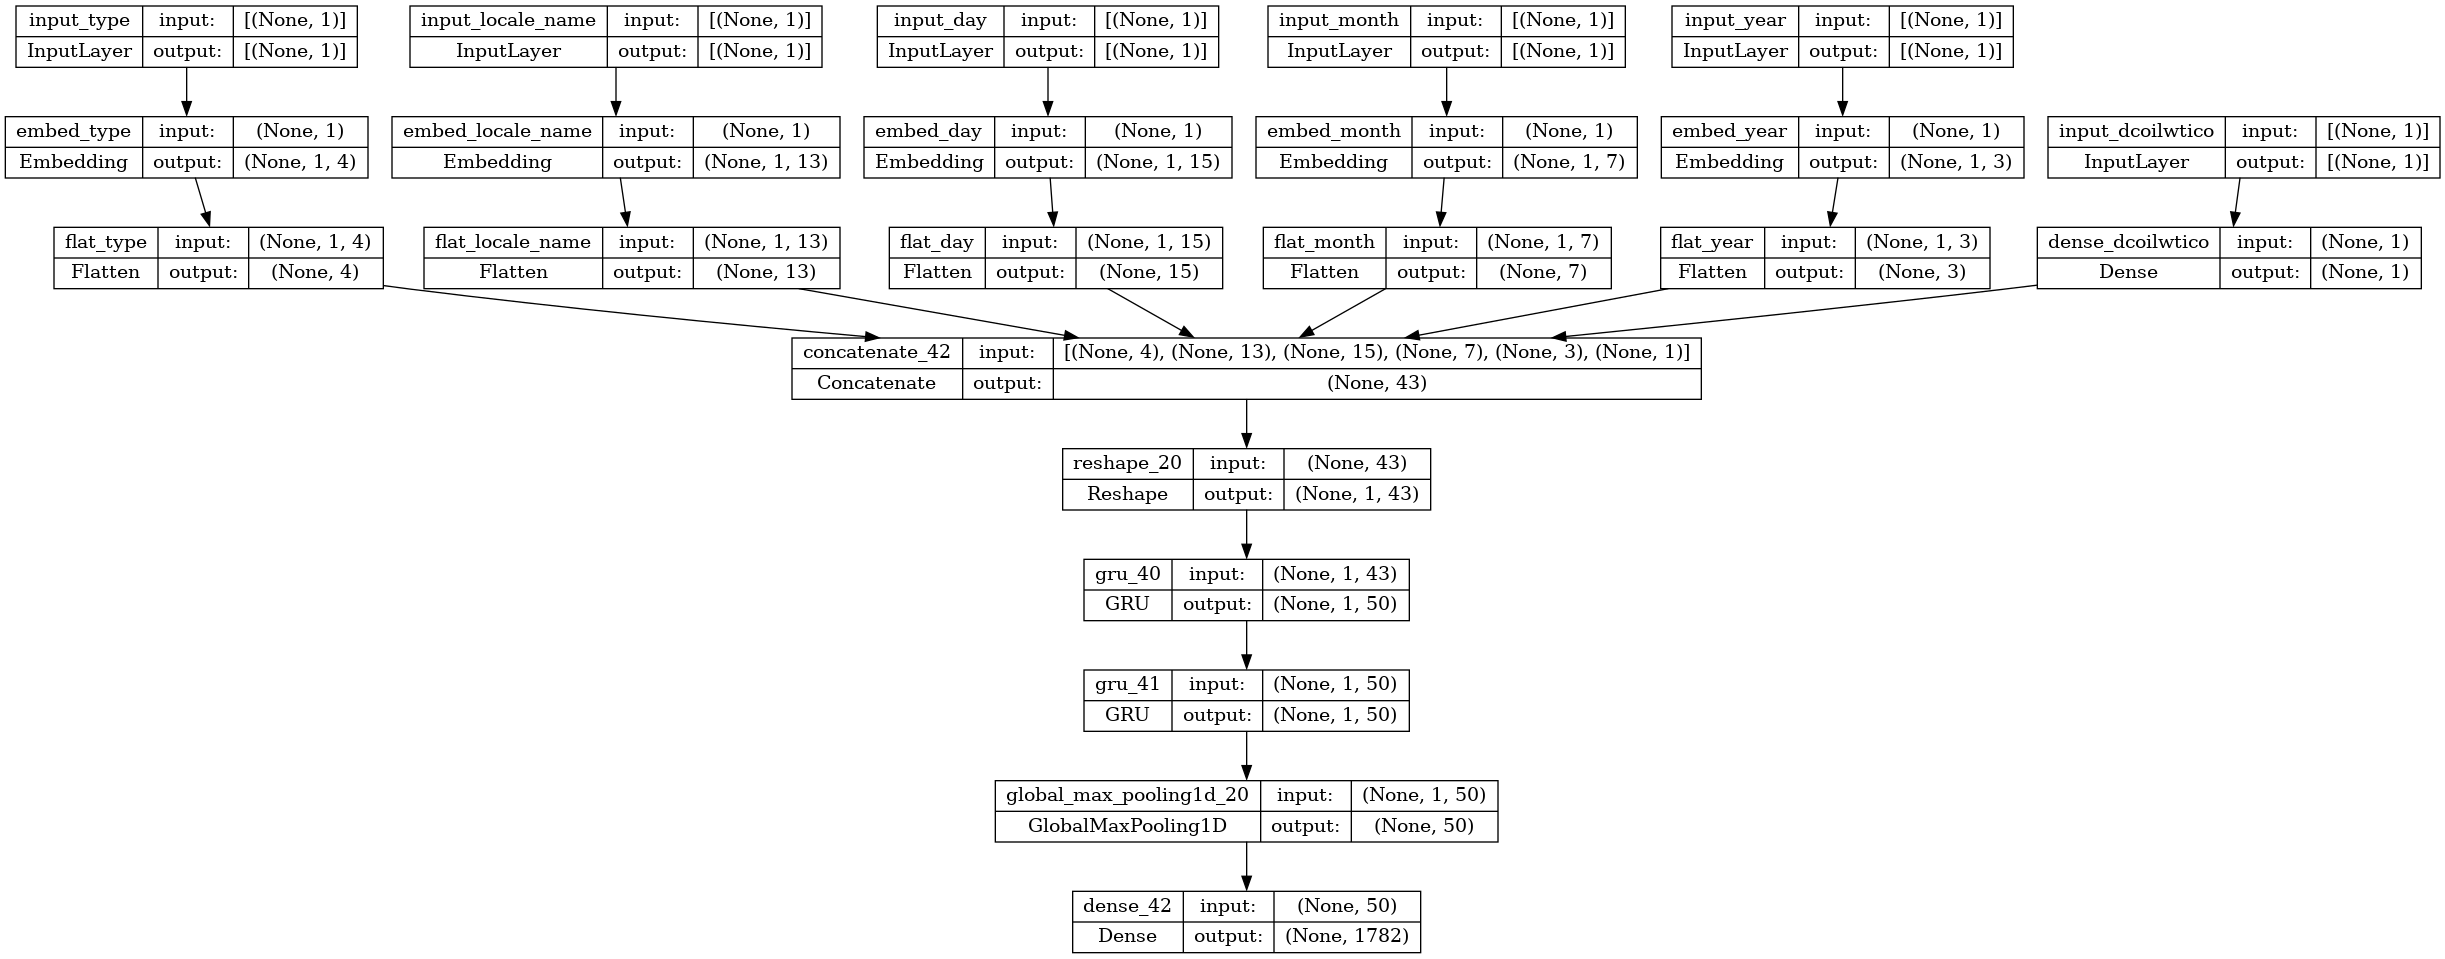

In [123]:
# 1st model, small model with one-hot encoding
model_small_onehot = get_small_model(is_onehot=True)
model_small_onehot.compile(optimizer=Adam(learning_rate=0.1, amsgrad=True), loss=RMSLE)

# 2nd model, small model with entity embedding
model_small_embed = get_small_model(is_onehot=False)
model_small_embed.compile(optimizer=Adam(learning_rate=0.001, amsgrad=True), loss=RMSLE)

# 3rd model, full model with one-hot encoding
model_full_onehot = get_full_model(is_onehot=True)
model_full_onehot.compile(optimizer=Adam(learning_rate=0.001, amsgrad=True), loss=RMSLE)

# 4th model, full model with entity embedding
model_full_embed = get_full_model(is_onehot=False)
model_full_embed.compile(optimizer=Adam(learning_rate=0.0003, amsgrad=True), loss=RMSLE)


# Plots all 4 models
# print("model_small_onehot")
# plot_model(model_small_onehot, show_shapes=True)
# print("model_small_embed")
# plot_model(model_small_embed, show_shapes=True)
# print("model_full_onehot")
# plot_model(model_full_onehot, show_shapes=True)
print("model_full_embed")
plot_model(model_full_embed, show_shapes=True)

### 1st model, Small model with one-hot encoding

The final loss is `0.97`.

6/6 [==============================] - 0s 4ms/step - loss: 0.9752
Final validaion loss:  0.9751735329627991


,loss,val_loss
29,1.095343,1.043858
30,1.087212,1.021958
31,1.038439,0.976689
32,1.036658,0.978080
33,1.023201,0.975174


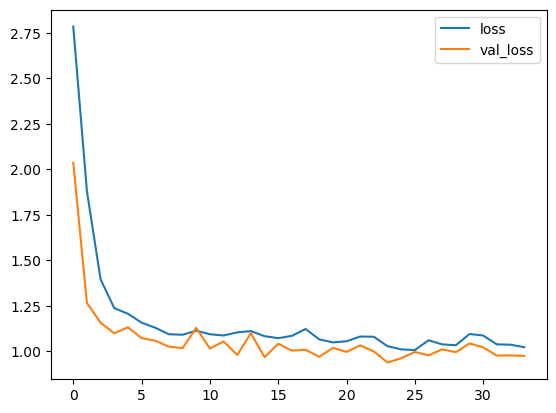

In [124]:
# Train model
history = fit_model(model_small_onehot, X_train, y_train, X_val, y_val, epochs, bs, callbacks)
# Evaluate model
results = pd.DataFrame(history.history)
results[["loss", "val_loss"]].plot()
print("Final validaion loss: ", model_small_onehot.evaluate(preprocess(X_val), y_val))
results.tail()

### 2nd model, Small model with embedding

The final loss is `0.79`. It improved about 0.2 from one-hot encoding. It could have potential to grasp this dataset's feature well.

6/6 [==============================] - 0s 4ms/step - loss: 0.7965
Final validaion loss:  0.796473503112793


,loss,val_loss
192,0.918566,0.795386
193,0.917934,0.794060
194,0.922832,0.793057
195,0.923181,0.793637
196,0.911464,0.796474


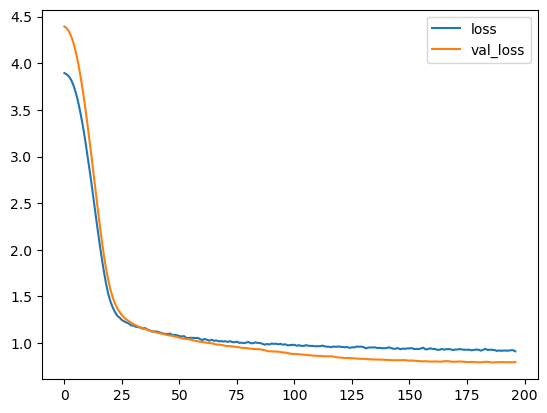

In [125]:
# Train model
history = fit_model(model_small_embed, X_train, y_train, X_val, y_val, epochs, bs, callbacks)
# Evaluate model
results = pd.DataFrame(history.history)
results[["loss", "val_loss"]].plot()
print("Final validaion loss: ", model_small_embed.evaluate(preprocess(X_val), y_val))
results.tail()

### 3rd model, Full model with one-hot encoding

The final loss is `0.78`. 

6/6 [==============================] - 0s 4ms/step - loss: 0.7834
Final validaion loss:  0.7834376692771912


,loss,val_loss
195,0.783628,0.783908
196,0.783597,0.783800
197,0.786490,0.783727
198,0.785264,0.783614
199,0.783638,0.783438


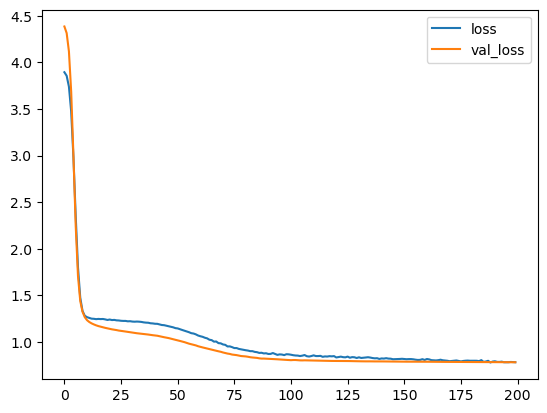

In [126]:
# Train model
history = fit_model(model_full_onehot, X_train, y_train, X_val, y_val, epochs, bs, callbacks)
# Evaluate model
results = pd.DataFrame(history.history)
results[["loss", "val_loss"]].plot()
print("Final validaion loss: ", model_full_onehot.evaluate(preprocess(X_val), y_val))
results.tail()

### 4th model, Full model with embedding

The final loss is `0.77`. It improved 0.02 from previous full model with one-hot encoding.

6/6 [==============================] - 0s 5ms/step - loss: 0.7765
Final validaion loss:  0.7765082716941833


,loss,val_loss
195,0.856495,0.777321
196,0.857186,0.777021
197,0.860531,0.776929
198,0.855327,0.776663
199,0.857277,0.776508


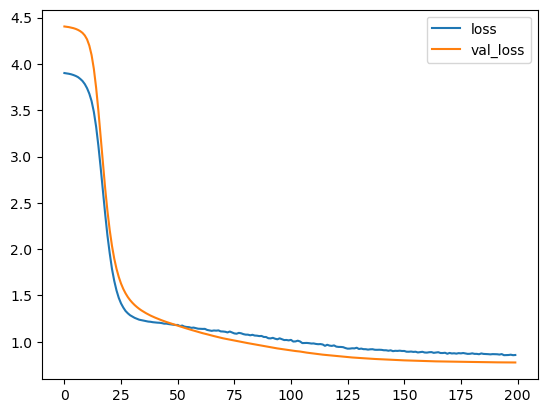

In [127]:
# Train model
history = fit_model(model_full_embed, X_train, y_train, X_val, y_val, epochs, bs, callbacks)
# Evaluate model
results = pd.DataFrame(history.history)
results[["loss", "val_loss"]].plot()
print("Final validaion loss: ", model_full_embed.evaluate(preprocess(X_val), y_val))
results.tail()

### Compare 4 model's performance

The best model is 4th model, full model with entity embedding. We tried some training, and overall best result would be the same as the table below. 

What we found are:
* entity embedding imprve the model's performance especially when model size is small. 
* the entity embedding would improve the training time due to its reduction technique.
* entity embedding can reduce the data's dimentionality while holding data's feature.

Note: This dataset is small number entries, `1542` row. Thus, if we add more data and update hyper parameters, the final result would differ from this notebook.

In [128]:
data = {
    'Small Model': [model_small_onehot.evaluate(preprocess(X_val), y_val), model_small_embed.evaluate(preprocess(X_val), y_val)],
    'Full Model': [model_full_onehot.evaluate(preprocess(X_val), y_val), model_full_embed.evaluate(preprocess(X_val), y_val)]
}
compare_df = pd.DataFrame(data, columns=['Small Model', 'Full Model'], index=['OneHot', 'Embed'])
compare_df

6/6 [==============================] - 0s 5ms/step - loss: 0.7765


,Small Model,Full Model
OneHot,0.975174,0.783438
Embed,0.796474,0.776508


### (Option) Tune learning rate

We search best learning rates by below code. We trained 4 models with optimized hyper params.

In [122]:
# The code is based on kaggle notebook, "Tuning your lerarning rate" by Aleksey Bilogur
# The original code :https://www.kaggle.com/code/residentmario/tuning-your-learning-rate/notebook

# from keras.callbacks import LearningRateScheduler

# epochs = 100
# # Replace model
# history = fit_model(model_full_embed, X_train, y_train, X_val, y_val, epochs, bs, callbacks=[
#         LearningRateScheduler(
#             lambda epoch: 3e-4 * 10 ** (epoch / 30)
#         )
#     ], verbose=1)
# # Evaluate model
# results = pd.DataFrame(history.history)
# results[["loss", "val_loss"]].plot()
# print("Final validaion loss: ", model_small_onehot.evaluate(preprocess(X_val), y_val))
# results.tail()

## Interpret model with entity embedding

OK, we trained all 4 models and compare performance with each other. We found entity embedding can help to make better models, but how? We, engineers need to explain how it works, what makes model learn easily with less dimentionality to other stake holders. 

Basically, deep learning seems "black box" to the human, even to the model's builder. However, entity embeding layers can show us what model see the data visually. The below images indicate how data lookes like to the model while training. Let's see 2 categories, `month` and `City` data.

What we found are:
* month data are obiously divided into 2 parts, one for first half and another for last half of the year. 7 and 8th moth are exceptions for that.
* city data can not be learned weill to the model, just by comparing its relationships on real geograhical data. The original paper indicates that if model fit the data well, it's embed city location are close to the real.

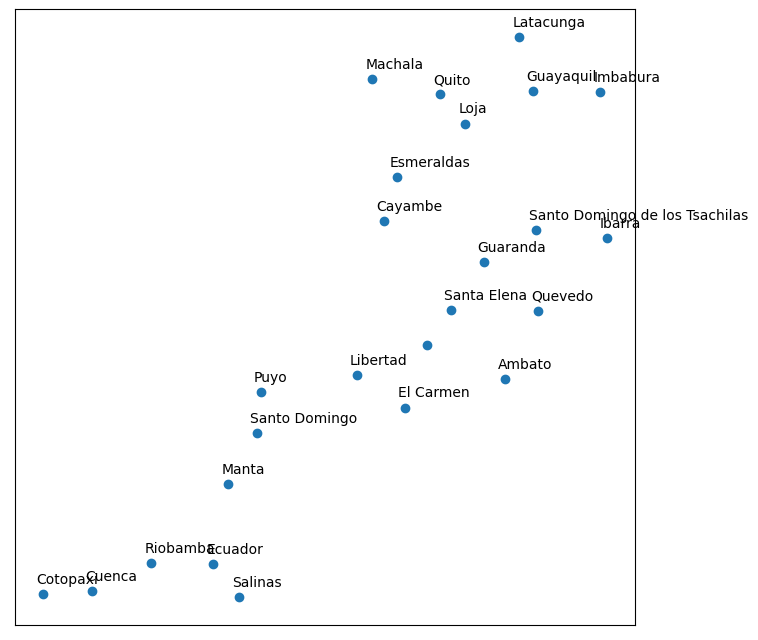

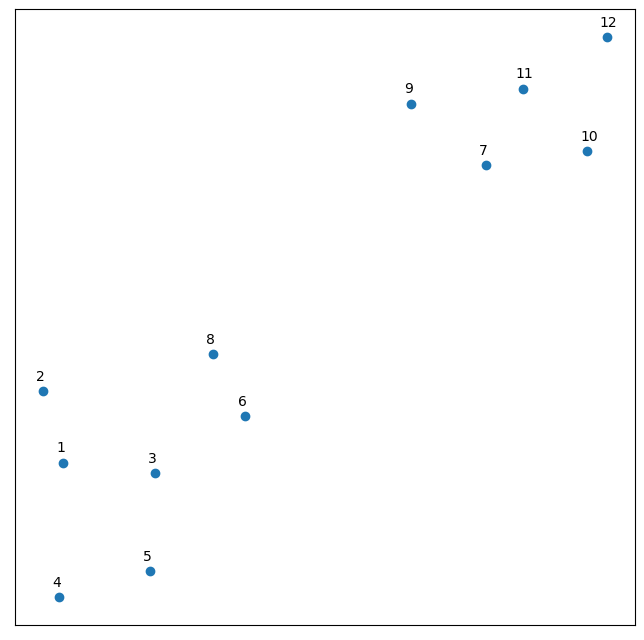

In [130]:
display(Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/9/9a/Ecuador%2C_administrative_divisions_-_es_-_colored.svg/1920px-Ecuador%2C_administrative_divisions_-_es_-_colored.svg.png', width=650, unconfined=True))
plot_embedding_feature(model_small_embed, "locale_name")
plot_embedding_feature(model_small_embed, "month")

## Discussion

The best result we made is `0.776508` in RMSLE metric. We can conclude that entity embedding can be applied to other tabular datasets. Also, it can improve the model performance whatever size the model is. The best result would be from full model with entity embedding in our datasets.

The challenge in this projects are following:

* Many times, our model produce NAN. If dataframe has one null value, it produces NAN. Also many bactch size and some other optimizer cause NAN. We just reduce batch size to fix that issue.
* Tabular data has many different data, in our case, numeric and categorical. We tried 2 ways to combine them, one hot encoding and entity embedding. Which one is better? It depents on the dataset and model's architecture.
* Entity embedding are sensitive to hyper parameter, while one-hot encoding are not. We first feed target data as is, but it cause model's learning badly. Thus, we decided to logarithm to reduce its deviation.
* Entity embedding have good interpretation feature, just we saw in previous part. It can be helpful to explain model's learning visually.

Here is future feature that might help our model fit data more:
* Data augumentatin to tabular data, since this dataset has little entries.
* Using pretrained embeddnig layers as feature extraction, with other ML or DL models. We can apply transfer our trained embedding layers to other DL models, just we do in transfer learning.

## Conclusion

We show a DL model for forecasting store sales data in Ecuador using entity embedding for categorical data. Entity embedding is a technique that maps high cardinality categorical variables to a low-dimensional vector space where each category is represented as a vector of fixed dimensionality. We compare the performance of four models, two with one-hot encoding and two with entity embedding. The models' performance is evaluated using the Root Mean Squared Logarithmic Error (RMSLE) metric. The best result achieved is 0.776508 in RMSLE metric, using entity embedding. We found that entity embedding can improve model performance regardless of model size and its architecture.

## Reference

* This project's github repo: https://github.com/Akitsuyoshi/intro_dl_week6
* The original paper for entity embedding: https://arxiv.org/abs/1604.06737
* The original implementation for entity embedding: https://github.com/entron/entity-embedding-rossmann
* The kaggle's original competition: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview/frequently-asked-questions
* The RMSLE loss function implementation: https://github.com/autonomio/talos/blob/master/talos/metrics/keras_metrics.py
* Normalization strategy to dataframe for DL model: https://datascience.stackexchange.com/questions/16692/keras-how-to-normalize-dataframe-with-continuous-and-categorical-data
* Tips to fix nan loss for regression while training: https://github.com/keras-team/keras/issues/2134